In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#@title prepare for prediction
def prepareForSVMPrediction(frame_data , keypoint_columns):
  new_data = pd.DataFrame([frame_data])

  for col in keypoint_columns:
      new_data[col + '_x'] = new_data[col].apply(lambda x: x[0])
      new_data[col + '_y'] = new_data[col].apply(lambda x: x[1])
  # Drop the original columns
  new_data.drop(columns=keypoint_columns, inplace=True)
  return new_data
def prepareForPrediction(frame_data , keypoint_columns):
  new_data = pd.DataFrame([frame_data])
  data = np.array([new_data.iloc[i].values.tolist() for i in range(len(new_data))])
  # Drop the original columns
  return data



##MediaPipe


In [23]:
#@title Libraries
from google.colab import drive
drive.mount('/content/drive')
!pip install -q mediapipe
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import pandas as pd
import cv2
import os
from google.colab.patches import cv2_imshow
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module='google.protobuf.symbol_database')
import matplotlib
matplotlib.use('TkAgg')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ImportError: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'headless' is currently running

In [5]:
#@title Helper functions for visualization

'''
0 - nose
1 - left eye (inner)
2 - left eye 1
3 - left eye (outer)
4 - right eye (inner)
5 - right eye 2
6 - right eye (outer)
7 - left ear 3
8 - right ear 4
9 - mouth (left)
10 - mouth (right)
11 - left shoulder 5
12 - right shoulder 6
13 - left elbow 7
14 - right elbow 8
15 - left wrist 9
16 - right wrist 10
17 - left pinky
18 - right pinky
19 - left index
20 - right index
21 - left thumb
22 - right thumb
23 - left hip 11
24 - right hip 12
25 - left knee 13
26 - right knee 14
27 - left ankle 15
28 - right ankle 16
29 - left heel
30 - right heel
31 - left foot index
32 - right foot index
'''
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}
mpkeys = [0,2,5,7,8,11,12,13,14,15,16,23,24,25,26,27,28]

def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)
  MPxy = []
  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]
    # x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  #
    for i in range(17):
      MPxy.append((pose_landmarks[mpkeys[i]].x , pose_landmarks[mpkeys[i]].y))

  # print('---------------------------','\n landmark count:',len(pose_landmarks),'Example landmarkObj at 0 \'nose\': ',pose_landmarks[1],'Example x , y , z',pose_landmarks[1].x,pose_landmarks[1].y , pose_landmarks[1].z , '\n--------------------------')

  return annotated_image , MPxy

In [6]:
#@title MediaPipe nn predict_video
MPkeypoint_columns = ['MediaPipe_nose',
       'MediaPipe_left_eye', 'MediaPipe_right_eye', 'MediaPipe_left_ear',
       'MediaPipe_right_ear', 'MediaPipe_left_shoulder',
       'MediaPipe_right_shoulder', 'MediaPipe_left_elbow',
       'MediaPipe_right_elbow', 'MediaPipe_left_wrist',
       'MediaPipe_right_wrist', 'MediaPipe_left_hip', 'MediaPipe_right_hip',
       'MediaPipe_left_knee', 'MediaPipe_right_knee', 'MediaPipe_left_ankle',
       'MediaPipe_right_ankle']

def predict_Fall_MP(mp_svm_model,VIDEO_IN,vid_num,mtype):
  base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
  options = vision.PoseLandmarkerOptions(
      base_options=base_options,
      output_segmentation_masks=True,running_mode=vision.RunningMode.VIDEO)
  detector = vision.PoseLandmarker.create_from_options(options)
  cap = cv2.VideoCapture(VIDEO_IN)
  fps = cap.get(cv2.CAP_PROP_FPS)

  time_step = 1.0 / fps
  preds = []
  # Get frame width and height
  frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  vidoe_data = []
  out_path = os.path.join(OUT_directory, f'MediaPipe_{mtype}_detected_video_{vid_num}.mp4')
  out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))

  num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  fall_detected = False
  fall_time = None


  # Initialize a variable to keep track of the current timestamp
  current_timestamp = 0.0
  idx = 0
  bar = display(progress(0, num_frames-1), display_id=True)

  # Loop through each frame in the video using VideoCapture#read()
  while cap.isOpened():
      ret, frame = cap.read()
      if not ret:
          break

      # Convert the frame received from OpenCV to a MediaPipe’s Image object.
      # Note: MediaPipe's Image object expects the data to be in RGB format.
      mpstart_time = time.time()


      rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)

      # You can process the mp_image_object further with MediaPipe solutions here.
      # Example: Use mp_image_object with a MediaPipe Face Detection model.
      timestamp_ms = current_timestamp * 1000
      timestamp_us = int(timestamp_ms * 1000)
      pose_landmarker_result = detector.detect_for_video(mp_image, timestamp_us)
      poses_count = len(pose_landmarker_result.pose_landmarks)
      annotated_image , MPxy = draw_landmarks_on_image(mp_image.numpy_view(), pose_landmarker_result)
      # cv2_imshow(annotated_image)

      frame_data = {}
      for i in range(17):
        keypoint_name = list(KEYPOINT_DICT.keys())[list(KEYPOINT_DICT.values()).index(i)]
        if poses_count > 0:
          frame_data[f'MediaPipe_{keypoint_name}'] = [MPxy[i][0],MPxy[i][1]]
        else:
          frame_data[f'MediaPipe_{keypoint_name}'] = [0.00,0.00]

      # Save the frame to the output video

      prediction = mp_svm_model.predict(prepareForPrediction(frame_data , MPkeypoint_columns))
      # print('prediction:: ',prediction)

      label = 'Fall' if prediction[0][0] > 0.7 else 'Not Fall'
      # print(prediction)
      preds.append(prediction[0][0])
      # label = 'PREDECTING'#predictions[0]
      cv2.putText(annotated_image,f'{label}: {(prediction[0][0]*100):.2f}%', (10, 30),
          cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 255, 0) if label == 'Not Fall' else (0, 0, 255), 2)


      title_text = 'Pose by MediaPipe'
      text_size, _ = cv2.getTextSize(title_text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
      text_width, text_height = text_size

      cv2.putText(annotated_image, title_text, (frame_width - 350, 30),
          cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)



      timestamp_text = f'Time: {current_timestamp:.2f}s'
      cv2.putText(annotated_image, timestamp_text,(30, frame_height - 20),
          cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 255, 0) if label == 'Not Fall' else (0, 0, 255), 2)

      if label == 'Fall' and not fall_detected:
          fall_time = current_timestamp
          fall_detected = True

      # Display the fall detection time if a fall was detected
      if fall_detected:
          fall_time_text = f'Fall detected at: {fall_time:.2f} s'
          cv2.putText(annotated_image, fall_time_text, (10, 100),
                      cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)


      out.write(annotated_image)

      mpend_time = time.time()
      mpexecution_time = (mpend_time - mpstart_time) * 1000  # convert to milliseconds

      mp_vid = {
      'Video_num':vid_num,
      'frame_indx':idx ,
      'predictions':prediction[0][0],
      'frame_proccessing_duration':mpexecution_time,
      'fall_detection_duration_perVideo':fall_time ,
      'frame_width': frame_width,
      'frame_height': frame_height
      }

      vidoe_data.append(mp_vid)

      current_timestamp += time_step
      # print(f"Frame: {idx} / {num_frames}")
      bar.update(progress(idx, num_frames-1))
      idx += 1
      if cv2.waitKey(int(1000/fps)) & 0xFF == ord('q'):
          break
  vidoe_datadf = pd.DataFrame(vidoe_data)
  csv_path = os.path.join(OUT_directory,f'MediaPipe_{mtype}_results_vid{vid_num}.csv')
  vidoe_datadf.to_csv(csv_path, index=False)


  cap.release()
  out.release()
  cv2.destroyAllWindows()
  return preds , fall_time

In [7]:
#@title MediaPipe svm predict_video
MPkeypoint_columns = ['MediaPipe_nose',
       'MediaPipe_left_eye', 'MediaPipe_right_eye', 'MediaPipe_left_ear',
       'MediaPipe_right_ear', 'MediaPipe_left_shoulder',
       'MediaPipe_right_shoulder', 'MediaPipe_left_elbow',
       'MediaPipe_right_elbow', 'MediaPipe_left_wrist',
       'MediaPipe_right_wrist', 'MediaPipe_left_hip', 'MediaPipe_right_hip',
       'MediaPipe_left_knee', 'MediaPipe_right_knee', 'MediaPipe_left_ankle',
       'MediaPipe_right_ankle']

def predict_Fall_SVM_MP(mp_svm_model,VIDEO_IN,vid_num):
  base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
  options = vision.PoseLandmarkerOptions(
      base_options=base_options,
      output_segmentation_masks=True,running_mode=vision.RunningMode.VIDEO)
  detector = vision.PoseLandmarker.create_from_options(options)
  cap = cv2.VideoCapture(VIDEO_IN)
  fps = cap.get(cv2.CAP_PROP_FPS)

  time_step = 1.0 / fps
  preds = []
  # Get frame width and height
  frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  vidoe_data = []
  out_path = os.path.join(OUT_directory, f'MediaPipe_SVM_detected_video_{vid_num}.mp4')
  out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))

  num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  fall_detected = False
  fall_time = None


  # Initialize a variable to keep track of the current timestamp
  current_timestamp = 0.0
  idx = 0
  bar = display(progress(0, num_frames-1), display_id=True)

  # Loop through each frame in the video using VideoCapture#read()
  while cap.isOpened():
      ret, frame = cap.read()
      if not ret:
          break

      # Convert the frame received from OpenCV to a MediaPipe’s Image object.
      # Note: MediaPipe's Image object expects the data to be in RGB format.
      mpstart_time = time.time()


      rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)

      # You can process the mp_image_object further with MediaPipe solutions here.
      # Example: Use mp_image_object with a MediaPipe Face Detection model.
      timestamp_ms = current_timestamp * 1000
      timestamp_us = int(timestamp_ms * 1000)
      pose_landmarker_result = detector.detect_for_video(mp_image, timestamp_us)
      poses_count = len(pose_landmarker_result.pose_landmarks)
      annotated_image , MPxy = draw_landmarks_on_image(mp_image.numpy_view(), pose_landmarker_result)
      # cv2_imshow(annotated_image)

      frame_data = {}
      for i in range(17):
        keypoint_name = list(KEYPOINT_DICT.keys())[list(KEYPOINT_DICT.values()).index(i)]
        if poses_count > 0:
          frame_data[f'MediaPipe_{keypoint_name}'] = [MPxy[i][0],MPxy[i][1]]
        else:
          frame_data[f'MediaPipe_{keypoint_name}'] = [0.00,0.00]

      # Save the frame to the output video

      prediction = mp_svm_model.predict(prepareForSVMPrediction(frame_data , MPkeypoint_columns))
      label = 'Fall' if prediction[0] == 1 else 'Not Fall'
      # print(prediction)
      preds.append(prediction[0])
      # label = 'PREDECTING'#predictions[0]
      cv2.putText(annotated_image,f'{label}: {prediction}', (10, 30),
          cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 255, 0) if label == 'Not Fall' else (0, 0, 255), 2)


      title_text = 'Pose by MediaPipe'
      text_size, _ = cv2.getTextSize(title_text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
      text_width, text_height = text_size

      cv2.putText(annotated_image, title_text, (frame_width - 350, 30),
          cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)



      timestamp_text = f'Time: {current_timestamp:.2f}s'
      cv2.putText(annotated_image, timestamp_text,(30, frame_height - 20),
          cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 255, 0) if label == 'Not Fall' else (0, 0, 255), 2)

      if label == 'Fall' and not fall_detected:
          fall_time = current_timestamp
          fall_detected = True

      # Display the fall detection time if a fall was detected
      if fall_detected:
          fall_time_text = f'Fall detected at: {fall_time:.2f} s'
          cv2.putText(annotated_image, fall_time_text, (10, 100),
                      cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)


      out.write(annotated_image)

      mpend_time = time.time()
      mpexecution_time = (mpend_time - mpstart_time) * 1000  # convert to milliseconds

      mp_vid = {
      'Video_num':vid_num,
      'frame_indx':idx ,
      'predictions':prediction[0],
      'frame_proccessing_duration':mpexecution_time,
      'fall_detection_duration_perVideo':fall_time ,
      'frame_width': frame_width,
      'frame_height': frame_height
      }

      vidoe_data.append(mp_vid)

      current_timestamp += time_step
      # print(f"Frame: {idx} / {num_frames}")
      bar.update(progress(idx, num_frames-1))
      idx += 1
      if cv2.waitKey(int(1000/fps)) & 0xFF == ord('q'):
          break
  vidoe_datadf = pd.DataFrame(vidoe_data)
  csv_path = os.path.join(OUT_directory,f'MediaPipe_SVM_results_vid{vid_num}.csv')
  vidoe_datadf.to_csv(csv_path, index=False)


  cap.release()
  out.release()
  cv2.destroyAllWindows()
  return preds , fall_time

##MoveNet

In [8]:
#@title Libraries
!pip install -q git+https://github.com/tensorflow/docs
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import pandas as pd
from tqdm.notebook import tqdm
import os
# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

  Preparing metadata (setup.py) ... done


In [9]:
#@title Model

model_name = "movenet_lightning" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

In [10]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  MNxy = []
  for i in range(17):
    kpts_x = keypoints_with_scores[:, :, i, 1][0][0]
    kpts_y = keypoints_with_scores[:, :, i, 0][0][0]
    MNxy.append((kpts_x,kpts_y))


  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [11]:
#@title Cropping Algorithm

# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
  """Defines the default crop region.

  The function provides the initial crop region (pads the full image from both
  sides to make it a square image) when the algorithm cannot reliably determine
  the crop region from the previous frame.
  """
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }

def torso_visible(keypoints):
  """Checks whether there are enough torso keypoints.

  This function checks whether the model is confident at predicting one of the
  shoulders/hips which is required to determine a good crop region.
  """
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  """Calculates the maximum distance from each keypoints to the center location.

  The function returns the maximum distances from the two sets of keypoints:
  full 17 keypoints and 4 torso keypoints. The returned information will be
  used to determine the crop size. See determineCropRegion for more detail.
  """
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x

  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y

    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
  """Determines the region to crop the image for the model to run inference on.

  The algorithm uses the detected joints from the previous frame to estimate
  the square region that encloses the full body of the target person and
  centers at the midpoint of two hip joints. The crop size is determined by
  the distances between each joints and the center point.
  When the model is not confident with the four torso joint predictions, the
  function returns a default crop which is the full image padded to square.
  """
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] +
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] +
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)

    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

def run_inference(movenet, image, crop_region, crop_size):
  """Runs model inference on the cropped region.

  The function runs the model inference on the cropped region and updates the
  model output to the original image coordinate system.
  """
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = movenet(input_image)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1]) / image_width

  return keypoints_with_scores





In [12]:
#@title extract_keypoints
def body_visible(keypoints):
  """Checks whether there are enough BODY keypoints.

  This function checks whether the model is confident at predicting one of the
  ** shoulders / hips / knees **
  which is required to determine a good frame.
  """
  KEYPOINT_SCORE = 0.3
  return (keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           KEYPOINT_SCORE and
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           KEYPOINT_SCORE and
          keypoints[0, 0, KEYPOINT_DICT['right_knee'], 2] >
           KEYPOINT_SCORE and
          keypoints[0, 0, KEYPOINT_DICT['left_knee'], 2] >
           KEYPOINT_SCORE and
          keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           KEYPOINT_SCORE and
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           KEYPOINT_SCORE)

In [13]:
#@title MoveNet Lightning nn predict_video

def predict_Fall_MVLight(mv_svm_model,VIDEO_IN,vid_num , mtype):

  cap = cv2.VideoCapture(VIDEO_IN)
  fps = cap.get(cv2.CAP_PROP_FPS)

  time_step = 1.0 / fps
  preds = []
  # Get frame width and height
  frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  out_path = os.path.join(OUT_directory, f'MoveNetLightning_{mtype}_detected_video_{vid_num}.mp4')
  out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))
  vidoe_data = []

  num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  # Initialize a variable to keep track of the current timestamp
  current_timestamp = 0.0
  idx = 0
  bar = display(progress(0, num_frames-1), display_id=True)

  crop_region = init_crop_region(frame_height, frame_width)

  fall_detected = False
  fall_time = None

  # Loop through each frame in the video using VideoCapture#read()
  while cap.isOpened():
      ret, frame = cap.read()
      if not ret:
          break

      # Convert the frame received from OpenCV to a MediaPipe’s Image object.
      # Note: MediaPipe's Image object expects the data to be in RGB format.
      mpstart_time = time.time()

      rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      keypoints_with_scores = run_inference(
          movenet, rgb_frame, crop_region, crop_size=[input_size, input_size])

      annotated_image = draw_prediction_on_image(
          rgb_frame.astype(np.uint8), keypoints_with_scores, crop_region=None,
          close_figure=True, output_image_height=frame_height)

      crop_region = determine_crop_region(
          keypoints_with_scores, frame_height, frame_width)

      #   MvLight_keypoint_columns

      frame_data = {}
      for i in range(17):
          kpts_x = keypoints_with_scores[:, :, i, 1][0][0]
          kpts_y = keypoints_with_scores[:, :, i, 0][0][0]
          kpts_scores = keypoints_with_scores[:, :, i, 2][0][0]
          keypoint_name = list(KEYPOINT_DICT.keys())[list(KEYPOINT_DICT.values()).index(i)]
          frame_data[f'MoveNetLightning_{keypoint_name}'] = [kpts_x, kpts_y]

      # PREDICTION SHOULD HAPPEN HERE USING frame_data
      prediction = mv_svm_model.predict(prepareForPrediction(frame_data , MvLight_keypoint_columns))
      # print('prediction:: ',prediction)

      label = 'Fall' if prediction[0][0] > 0.7 else 'Not Fall'
      # print(prediction)
      preds.append(prediction[0][0])
      # label = 'PREDECTING'#predictions[0]
      cv2.putText(annotated_image,f'{label}: {(prediction[0][0]*100):.2f}%', (10, 30),
          cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 255, 0) if label == 'Not Fall' else (0, 0, 255), 2)


      title_text = 'Pose by MoveNet Lightning'
      text_size, _ = cv2.getTextSize(title_text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
      text_width, text_height = text_size
      cv2.putText(annotated_image, title_text, (frame_width - 350, 30),
          cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

      timestamp_text = f'Time: {current_timestamp:.2f}s'
      cv2.putText(annotated_image, timestamp_text, (30, frame_height - 20),
          cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 255, 0) if label == 'Not Fall' else (0, 0, 255), 2)

      if label == 'Fall' and not fall_detected:
          fall_time = current_timestamp
          fall_detected = True

      # Display the fall detection time if a fall was detected
      if fall_detected:
          fall_time_text = f'Fall detected at: {fall_time:.2f} s'
          cv2.putText(annotated_image, fall_time_text, (10, 100),
                      cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)



      # print('MoveNet annotated_image :', type(annotated_image) , annotated_image.shape )
      out.write(annotated_image)
      # cv2_imshow(annotated_image)

      mpend_time = time.time()
      mpexecution_time = (mpend_time - mpstart_time) * 1000  # convert to milliseconds

      mp_vid = {
      'Video_num':vid_num,
      'frame_indx':idx ,
      'predictions':prediction[0][0],
      'frame_proccessing_duration':mpexecution_time,
      'fall_detection_duration_perVideo':fall_time ,
      'frame_width': frame_width,
      'frame_height': frame_height
      }

      vidoe_data.append(mp_vid)


      current_timestamp += time_step
      # print(f"Frame: {idx} / {num_frames}")
      bar.update(progress(idx, num_frames-1))
      idx += 1
      if cv2.waitKey(int(1000/fps)) & 0xFF == ord('q'):
          break
  vidoe_datadf = pd.DataFrame(vidoe_data)
  csv_path = os.path.join(OUT_directory,f'MoveNetLightning_{mtype}_results_vid{vid_num}.csv')
  vidoe_datadf.to_csv(csv_path, index=False)


  cap.release()
  out.release()
  cv2.destroyAllWindows()
  return preds , fall_time

In [14]:
#@title MoveNet Lightning svm predict_video

MvLight_keypoint_columns = ['MoveNetLightning_nose', 'MoveNetLightning_left_eye', 'MoveNetLightning_right_eye',
                    'MoveNetLightning_left_ear', 'MoveNetLightning_right_ear',
                    'MoveNetLightning_left_shoulder', 'MoveNetLightning_right_shoulder',
                    'MoveNetLightning_left_elbow', 'MoveNetLightning_right_elbow',
                    'MoveNetLightning_left_wrist', 'MoveNetLightning_right_wrist',
                    'MoveNetLightning_left_hip', 'MoveNetLightning_right_hip',
                    'MoveNetLightning_left_knee', 'MoveNetLightning_right_knee',
                    'MoveNetLightning_left_ankle', 'MoveNetLightning_right_ankle']


def predict_Fall_SVM_MVLight(mv_svm_model,VIDEO_IN,vid_num):

  cap = cv2.VideoCapture(VIDEO_IN)
  fps = cap.get(cv2.CAP_PROP_FPS)

  time_step = 1.0 / fps
  preds = []
  # Get frame width and height
  frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  out_path = os.path.join(OUT_directory, f'MoveNetLightning_SVM_detected_video_{vid_num}.mp4')
  out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))
  vidoe_data = []

  num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  # Initialize a variable to keep track of the current timestamp
  current_timestamp = 0.0
  idx = 0
  bar = display(progress(0, num_frames-1), display_id=True)

  crop_region = init_crop_region(frame_height, frame_width)

  fall_detected = False
  fall_time = None

  # Loop through each frame in the video using VideoCapture#read()
  while cap.isOpened():
      ret, frame = cap.read()
      if not ret:
          break

      # Convert the frame received from OpenCV to a MediaPipe’s Image object.
      # Note: MediaPipe's Image object expects the data to be in RGB format.
      mpstart_time = time.time()

      rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      keypoints_with_scores = run_inference(
          movenet, rgb_frame, crop_region, crop_size=[input_size, input_size])

      annotated_image = draw_prediction_on_image(
          rgb_frame.astype(np.uint8), keypoints_with_scores, crop_region=None,
          close_figure=True, output_image_height=frame_height)

      crop_region = determine_crop_region(
          keypoints_with_scores, frame_height, frame_width)

      #   MvLight_keypoint_columns

      frame_data = {}
      for i in range(17):
          kpts_x = keypoints_with_scores[:, :, i, 1][0][0]
          kpts_y = keypoints_with_scores[:, :, i, 0][0][0]
          kpts_scores = keypoints_with_scores[:, :, i, 2][0][0]
          keypoint_name = list(KEYPOINT_DICT.keys())[list(KEYPOINT_DICT.values()).index(i)]
          frame_data[f'MoveNetLightning_{keypoint_name}'] = [kpts_x, kpts_y, kpts_scores]

      # PREDICTION SHOULD HAPPEN HERE USING frame_data
      prediction = mv_svm_model.predict(prepareForSVMPrediction(frame_data , MvLight_keypoint_columns))
      label = 'Fall' if prediction[0] == 1 else 'Not Fall'
      preds.append(prediction[0])
      cv2.putText(annotated_image,f'{label}: {prediction}', (10, 30),
          cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 255, 0) if label == 'Not Fall' else (0, 0, 255), 2)


      title_text = 'Pose by MoveNet Lightning'
      text_size, _ = cv2.getTextSize(title_text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
      text_width, text_height = text_size
      cv2.putText(annotated_image, title_text, (frame_width - 350, 30),
          cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

      timestamp_text = f'Time: {current_timestamp:.2f}s'
      cv2.putText(annotated_image, timestamp_text, (30, frame_height - 20),
          cv2.FONT_HERSHEY_SIMPLEX, 1,(0, 255, 0) if label == 'Not Fall' else (0, 0, 255), 2)

      if label == 'Fall' and not fall_detected:
          fall_time = current_timestamp
          fall_detected = True

      # Display the fall detection time if a fall was detected
      if fall_detected:
          fall_time_text = f'Fall detected at: {fall_time:.2f} s'
          cv2.putText(annotated_image, fall_time_text, (10, 100),
                      cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)



      # print('MoveNet annotated_image :', type(annotated_image) , annotated_image.shape )
      out.write(annotated_image)
      # cv2_imshow(annotated_image)

      mpend_time = time.time()
      mpexecution_time = (mpend_time - mpstart_time) * 1000  # convert to milliseconds

      mp_vid = {
      'Video_num':vid_num,
      'frame_indx':idx ,
      'predictions':prediction[0],
      'frame_proccessing_duration':mpexecution_time,
      'fall_detection_duration_perVideo':fall_time ,
      'frame_width': frame_width,
      'frame_height': frame_height
      }

      vidoe_data.append(mp_vid)


      current_timestamp += time_step
      # print(f"Frame: {idx} / {num_frames}")
      bar.update(progress(idx, num_frames-1))
      idx += 1
      if cv2.waitKey(int(1000/fps)) & 0xFF == ord('q'):
          break
  vidoe_datadf = pd.DataFrame(vidoe_data)
  csv_path = os.path.join(OUT_directory,f'MoveNetLightning_SVM_results_vid{vid_num}.csv')
  vidoe_datadf.to_csv(csv_path, index=False)


  cap.release()
  out.release()
  cv2.destroyAllWindows()
  return preds , fall_time

#Reformat Vlidation Set from images to videos

In [15]:
def make_video_from_frames(frames_folder, output_video):
    # Get all PNG files in the frames folder
    frame_files = sorted([f for f in os.listdir(frames_folder) if f.endswith('.png')])

    # Determine the width and height from the first image
    frame = cv2.imread(os.path.join(frames_folder, frame_files[0]))
    height, width, layers = frame.shape
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use lower case
    out = cv2.VideoWriter(output_video, fourcc, 30.0, (width, height))
    for i, f in enumerate(frame_files):
        filename = os.path.join(frames_folder, f)

        img = cv2.imread(filename)
        out.write(img)  # Write out frame to video
    print(f"Processes: {filename})")
    # Release everything if job is finished
    out.release()
    cv2.destroyAllWindows()

In [16]:
CREATE_VALID_SET = False
if CREATE_VALID_SET:
  for i in range(1,31):
    frames_folder = f'/content/drive/MyDrive/AI-RDP/VALIDATION_SET/fall-{i}-cam0-rgb'
    output_video = f'/content/drive/MyDrive/AI-RDP/VALIDATION_SET/fall{i}.mp4'
    make_video_from_frames(frames_folder, output_video)

#Prepare Prediction Models
Check that the models directories are correct here

In [17]:
from joblib import load
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import load_model
import time

mp_model_path = '/content/drive/MyDrive/AI-RDP/DEMO/MediaPipe_NN_model50Epochsv2.keras'
mp_mlp_model = load_model(mp_model_path)

mv_model_path = '/content/drive/MyDrive/AI-RDP/DEMO/MoveNet_NN_model50Epochsv2.keras'
mv_mlp_model = load_model(mv_model_path)
print("MLP Models loaded successfully.")


# Load the LSTM models
mp_lstm_model_path = '/content/drive/MyDrive/AI-RDP/DEMO/lstm_fall_detection_mpv2.h5'
mv_lstm_model_path = '/content/drive/MyDrive/AI-RDP/DEMO/lstm_fall_detection_mvv2.h5'

mp_lstm_model = load_model(mp_lstm_model_path)
mv_lstm_model = load_model(mv_lstm_model_path)

print("LSTM models loaded successfully.")

mp_model_path = '/content/drive/MyDrive/AI-RDP/DEMO/svm_MediaPipe_model.joblib'
mp_svm_model = load(mp_model_path)
mv_model_path = '/content/drive/MyDrive/AI-RDP/DEMO/svm_lightning_model.joblib'
mv_svm_model = load(mv_model_path)
print("Models loaded successfully.")

MLP Models loaded successfully.


LSTM models loaded successfully.


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Models loaded successfully.


#Predict the entire Validation Set

In [18]:
TEST_Validation = False
if TEST_Validation:
  mp_data = []
  mv_data = []

  for i in range(1,31):
    vid_num = i
    VIDPATH = f'/content/drive/MyDrive/AI-RDP/VALIDATION_SET/fall{vid_num}.mp4'
    MP_PREDS , mpstep= predict_Fall_SVM_MP(mp_svm_model,VIDPATH,vid_num)
    MV_PREDS , mvstep = predict_Fall_SVM_MVLight(mv_svm_model,VIDPATH,vid_num)
    print('Proccessed: ',VIDPATH)

  for i in range(1,31):
    vid_num = i
    VIDPATH = f'/content/drive/MyDrive/AI-RDP/VALIDATION_SET/fall{vid_num}.mp4'
    MP_PREDS , mpstep= predict_Fall_MP(mp_mlp_model,VIDPATH,vid_num,'mlp')
    MV_PREDS , mvstep = predict_Fall_MVLight(mv_mlp_model,VIDPATH,vid_num,'mlp')
    print('Proccessed: ',VIDPATH)
  for i in range(1,31):
    vid_num = i
    VIDPATH = f'/content/drive/MyDrive/AI-RDP/VALIDATION_SET/fall{vid_num}.mp4'
    MP_PREDS , mpstep= predict_Fall_MP(mp_lstm_model,VIDPATH,vid_num,'lstm')
    MV_PREDS , mvstep = predict_Fall_MVLight(mv_lstm_model,VIDPATH,vid_num,'lstm')
    print('Proccessed: ',VIDPATH)


# Create Demo Videos

In [19]:
#@title createDemoVideo
def createDemoVideo(vid_num , VIDPATH , TEST , mv_model , mp_model , mtype):
  if TEST:
    if mtype == 'svm':
      mpstart_time = time.time()
      MP_PREDS , mpstep= predict_Fall_SVM_MP(mp_model,VIDPATH,vid_num)
      mpend_time = time.time()
      mpexecution_time = (mpend_time - mpstart_time) * 1000  # convert to milliseconds

      mvstart_time = time.time()
      MV_PREDS , mvstep = predict_Fall_SVM_MVLight(mv_model,VIDPATH,vid_num)
      mvend_time = time.time()
      mvexecution_time = (mvend_time - mvstart_time) * 1000  # convert to milliseconds
    else:
      mpstart_time = time.time()
      MP_PREDS , mpstep= predict_Fall_MP(mp_model,VIDPATH,vid_num , mtype)
      mpend_time = time.time()
      mpexecution_time = (mpend_time - mpstart_time) * 1000  # convert to milliseconds
      mvstart_time = time.time()
      MV_PREDS , mvstep = predict_Fall_MVLight(mv_model,VIDPATH,vid_num , mtype)
      mvend_time = time.time()
      mvexecution_time = (mvend_time - mvstart_time) * 1000  # convert to milliseconds

### Main Part to Run
Set the path to the video to process

The output directory to save the files.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━

AttributeError: 'FigureCanvasAgg' object has no attribute 'tostring_rgb'

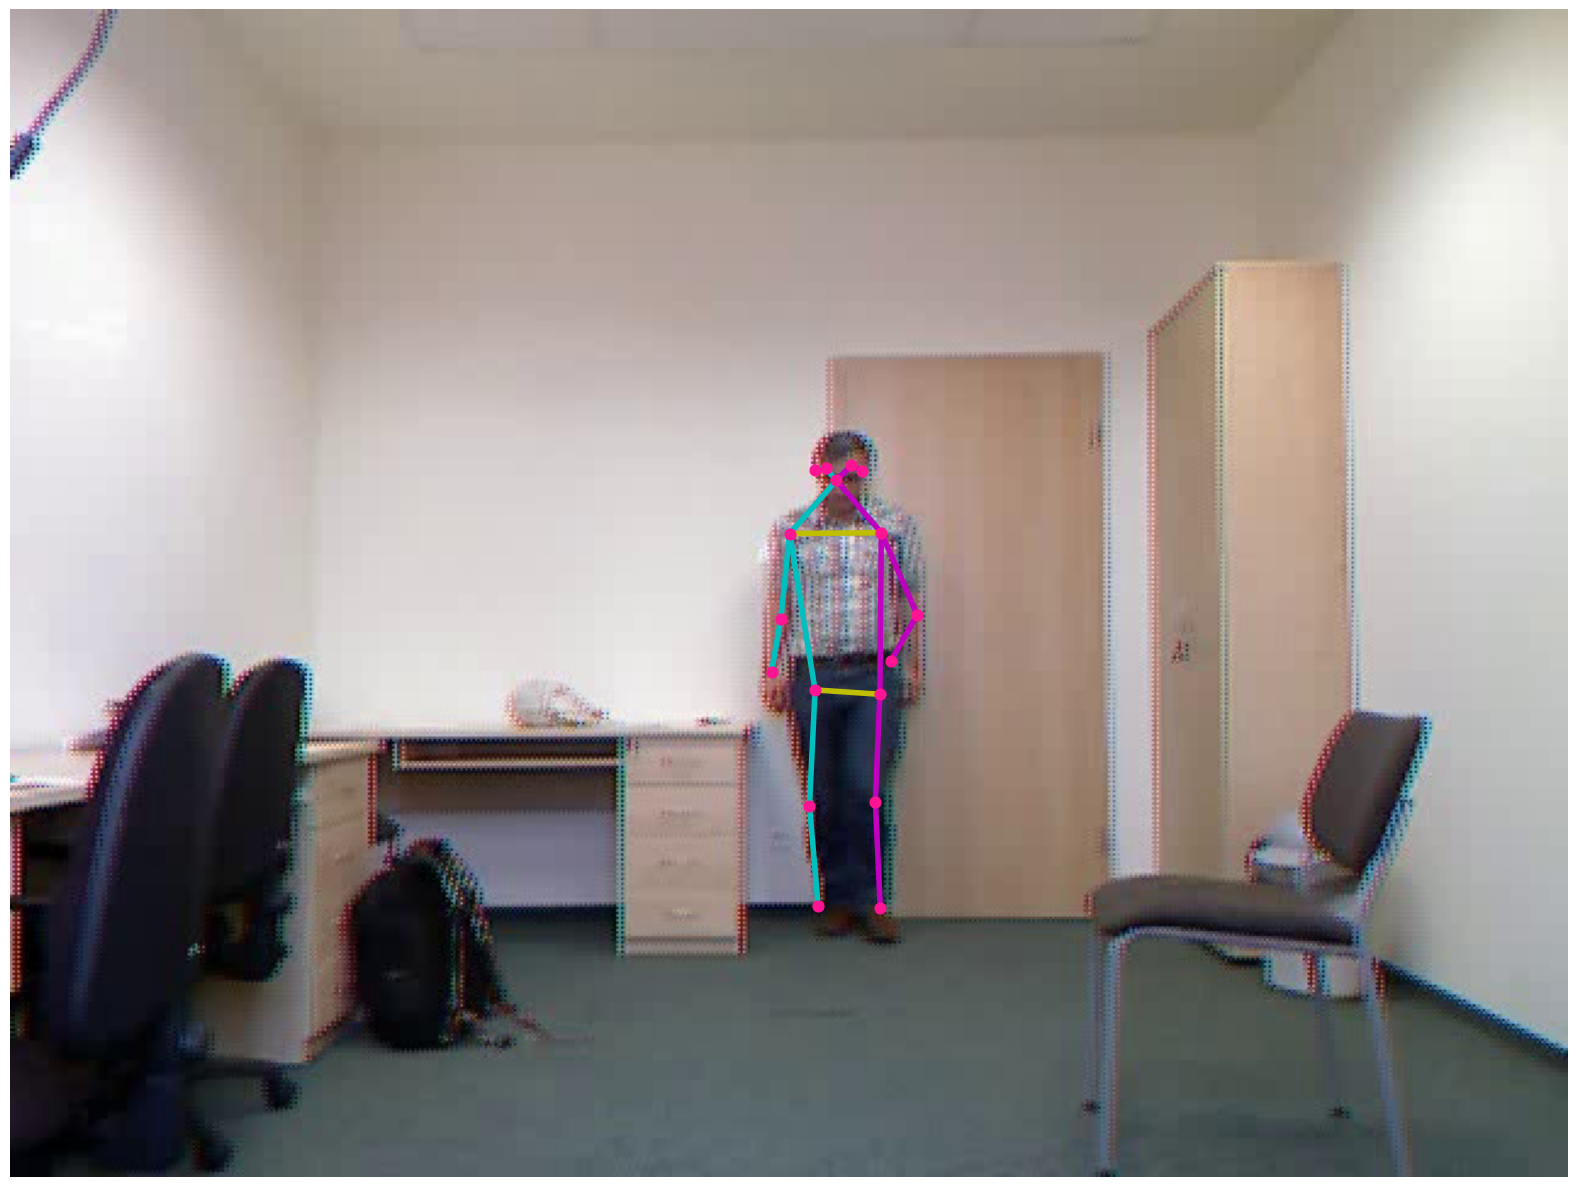

In [22]:
OUT_directory = '/content/drive/MyDrive/AI-RDP/DEMO'
VIDPATH = f'/content/drive/MyDrive/AI-RDP/DEMO/demo_video.mp4' #The path for the video to be processed

TEST = True
vid_num = 44

# createDemoVideo(vid_num , VIDPATH , TEST , mv_svm_model , mp_svm_model , 'svm')

# createDemoVideo(vid_num , VIDPATH , TEST , mv_mlp_model , mp_mlp_model , 'mlp')

createDemoVideo(vid_num , VIDPATH , TEST , mv_lstm_model , mp_lstm_model , 'lstm')

